<a href="https://colab.research.google.com/github/SharatGupta/DSML-Projects/blob/main/Zee_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

# Loading Data & Checking Structures

In [60]:
#!pip install gdown

In [61]:
!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 66.2MB/s]


In [62]:
!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:01<00:00, 19.1MB/s]


In [63]:
!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 70.4MB/s]


In [175]:
movies=pd.read_fwf("zee-movies.dat",encoding='ISO-8859-1')

In [65]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [66]:
movies.shape

(3883, 3)

In [67]:
movies.head(5)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [68]:
ratings=pd.read_fwf("zee-ratings.dat",encoding='ISO-8859-1')

In [69]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [70]:
ratings.shape

(1000209, 1)

In [71]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [72]:
users=pd.read_fwf("zee-users.dat",encoding='ISO-8859-1')

In [73]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [74]:
users.shape

(6040, 1)

In [75]:
users.head(5)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


# Extracting Features from each Dataset

## Movies

In [176]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


Let drop the Columns with Incompletely Filled Data

### Adding Unnamed 1 & unnamed 2

In [19]:
movies[~movies["Unnamed: 1"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
235,238::Far From Home: The Adventures of Yellow D...,ren',NaN
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
...,...,...,...
3727,"3796::Wisdom of Crocodiles, The (a.k.a. Immort...",ille,NaN
3752,"3822::Girl on the Bridge, The (La Fille sur le...",ce,NaN
3785,"3855::Affair of Love, An (Une Liaison Pornogra...",nce,NaN
3794,3864::Godzilla 2000 (Gojira ni-sen mireniamu) ...,ci-F,NaN


In [21]:
movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 1"].isnull()]["Unnamed: 1"]

In [22]:
movies[~movies["Unnamed: 2"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
262,265::Like Water for Chocolate (Como agua para ...,oman,e
290,"293::Professional, The (a.k.a. Leon: The Profe...",ma|R,mance|Thriller
359,"363::Wonderful, Horrible Life of Leni Riefenst...",lder,(1993)::Docum
464,"468::Englishman Who Went Up a Hill, But Came D...",::Co,edy|Romance
740,750::Dr. Strangelove or: How I Learned to Stop...,b (1,63)::Sci-Fi|Wa
781,"791::Last Klezmer: Leopold Kozlowski, His Life...",cume,tary


In [23]:
movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 2"].isnull()]["Unnamed: 2"]

### OLD

In [177]:
a= movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()
a.sum()

3783

In [178]:
movies = movies[movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()]

In [179]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3783 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3783 non-null   object
 1   Unnamed: 1               0 non-null      object
 2   Unnamed: 2               0 non-null      object
dtypes: object(3)
memory usage: 118.2+ KB


In [180]:
movies.drop(columns = ["Unnamed: 1","Unnamed: 2"], inplace=True)

In [181]:
movies.shape

(3783, 1)

In [182]:
movies.head(5)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


### splitting Features

In [183]:
movies.shape

(3783, 1)

In [184]:
movies["Movie ID"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
movies["Title"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
movies["Genres"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[-1])

In [84]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance,3,Grumpier Old Men (1995),Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama,4,Waiting to Exhale (1995),Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy,5,Father of the Bride Part II (1995),Comedy


In [185]:
movies["Genressplit"] = movies["Genres"].str.split("|")

In [186]:
movies = movies.explode("Genressplit")

In [187]:
movies.drop(columns= ["Movie ID::Title::Genres"], inplace = True)

In [ ]:
#movies.drop(columns= ["Unnamed: 1","Unnamed: 2"], inplace = True)

In [188]:
movies.head()

,Movie ID,Title,Genres,Genressplit
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's


In [196]:
movies["Releaseyear"] = movies["Title"].str.split("(").transform(lambda x : x[-1])

In [197]:
movies["Releaseyear"] = movies["Releaseyear"].str.split(")").transform(lambda x : x[0])

In [198]:
movies["Releaseyear"].value_counts()

1998    556
1996    527
1997    526
1995    525
1999    417
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Releaseyear, Length: 81, dtype: int64

In [199]:
movies["Genres"]=movies["Genres"].astype("category")
movies["Releaseyear"]=movies["Releaseyear"].astype("int")

In [200]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Movie ID     6174 non-null   object  
 1   Title        6174 non-null   object  
 2   Genres       6174 non-null   category
 3   Genressplit  6174 non-null   object  
 4   Releaseyear  6174 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 263.6+ KB


## Users

In [91]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [92]:
users["USerID"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[0])
users["Gender"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[1])
users["Age"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[2])
users["Occupation"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[3])
users["Zipcode"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[4])

In [93]:
users.drop(columns= ["UserID::Gender::Age::Occupation::Zip-code"], inplace = True)

In [94]:
users["Gender"]=users["Gender"].astype("category")
users["Occupation"]=users["Occupation"].astype("category")
users["Age"]=users["Age"].astype("category")
users["Zipcode"]=users["Zipcode"].astype("category")

In [95]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [96]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Ratings

In [97]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [98]:
ratings["USerID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[0])
ratings["Movie ID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[1])
ratings["Rating"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[2])
ratings["Timestamp"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[3])

In [99]:
ratings.drop(columns= ["UserID::MovieID::Rating::Timestamp"], inplace = True)

In [100]:
ratings["Rating"]=ratings["Rating"].astype("int")
ratings["Timestamp"]=ratings["Timestamp"].astype("int")

In [101]:
from datetime import datetime

In [102]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [103]:
ratings['dayofweek'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())

In [104]:
ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)
ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)

In [105]:
ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)

In [106]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [107]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


# Exploratory Data Analysis

## Movies

In [189]:
movies.head()

,Movie ID,Title,Genres,Genressplit
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's


In [190]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 25


In [191]:
movies["Genressplit"].value_counts().reset_index()

,index,Genressplit
0,Drama,1568
1,Comedy,1170
2,Action,485
3,Thriller,484
4,Romance,452
5,Horror,332
6,Adventure,257
7,Sci-Fi,255
8,Children's,227
9,Crime,208


In [192]:
movies.loc[movies["Genressplit"] =="Horro","Genressplit"] = "Horror"
movies.loc[movies["Genressplit"] =="Fantas","Genressplit"] = "Fantasy"
movies.loc[movies["Genressplit"] =="Dram","Genressplit"] = "Drama"
movies.loc[movies["Genressplit"] =="Wester","Genressplit"] = "Western"
movies.loc[movies["Genressplit"] =="Sci-F","Genressplit"] = "Sci-Fi"
movies.loc[movies["Genressplit"] =="Thrille","Genressplit"] = "Thriller"
movies.loc[movies["Genressplit"] =="Wa","Genressplit"] = "War"

In [193]:
movies["Genressplit"].nunique()

18

<Axes: xlabel='Genressplit', ylabel='count'>

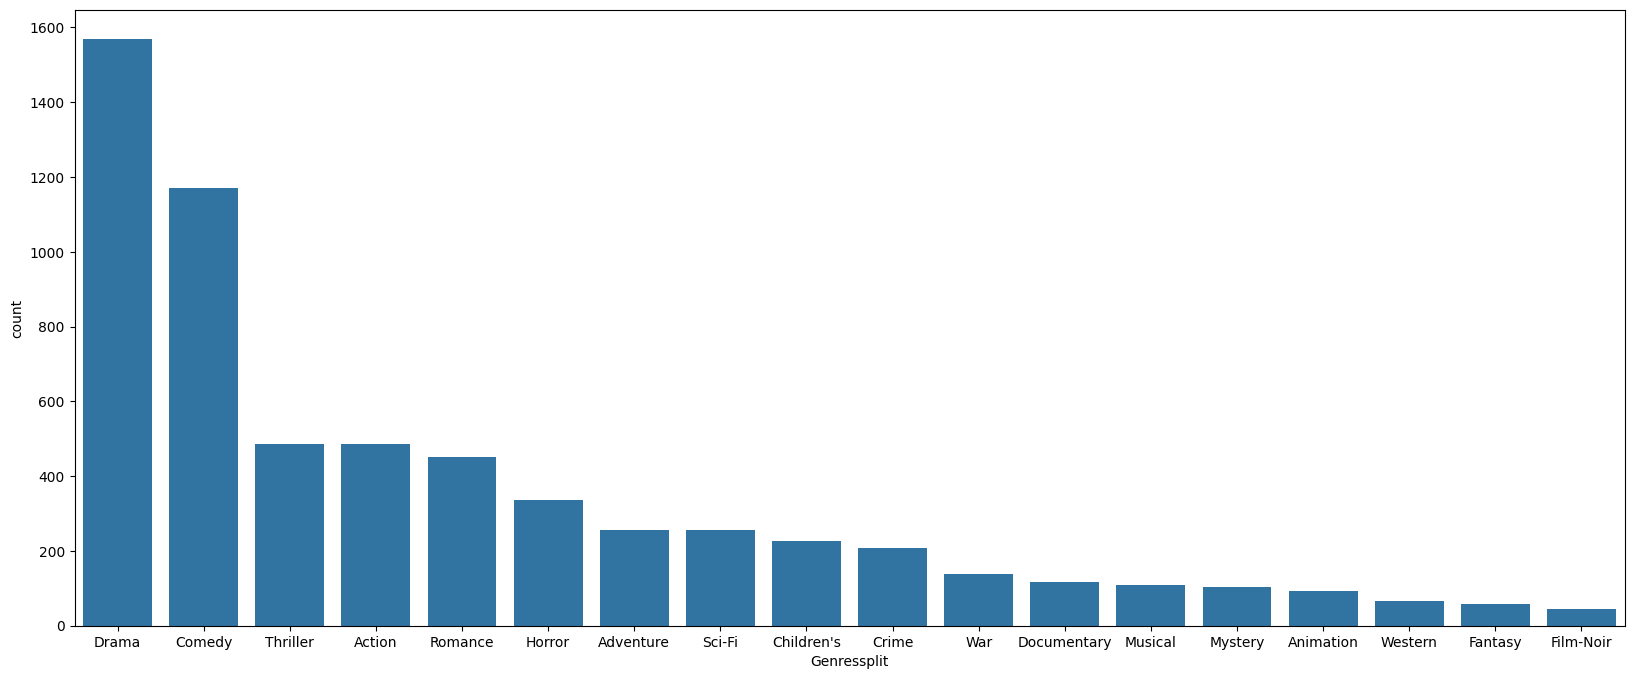

In [194]:
plt.figure(figsize =(20,8))
sns.countplot(data= movies, x="Genressplit", order = movies["Genressplit"].value_counts().reset_index()["index"])

In [160]:
movies.Releaseyear.describe()

count    6174.000000
mean     1986.229997
std        16.547598
min      1919.000000
25%      1983.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: Releaseyear, dtype: float64

<Axes: xlabel='Releaseyear', ylabel='Count'>

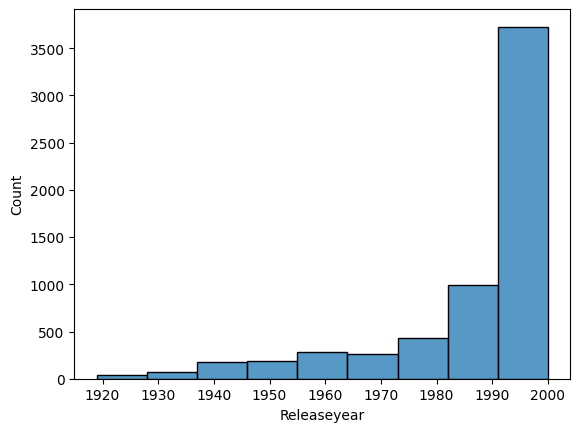

In [161]:
sns.histplot(data=movies, x= "Releaseyear", bins =9)

* lets Convert Release year into bins as Release year recency factor

In [201]:
bins = [1919,1940,1960,1980,1990,2000]
movies["Releaseyeargroups"] = pd.cut(movies["Releaseyear"], bins, labels=[1,2,3,4,5])

<Axes: xlabel='count', ylabel='Releaseyeargroups'>

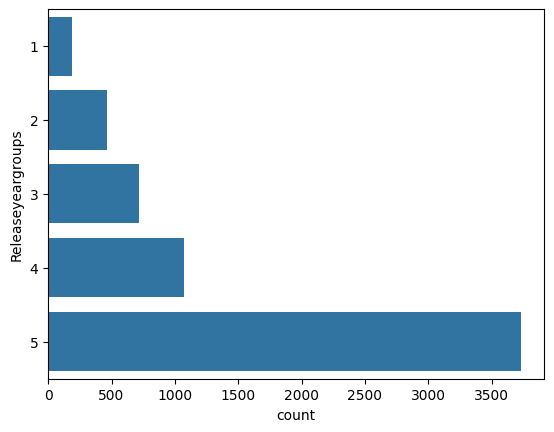

In [202]:
sns.countplot( movies["Releaseyeargroups"])

In [203]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 18
No of Unique Releaseyear are 81
No of Unique Releaseyeargroups are 5


## Users

In [ ]:
for i in users.columns:
  print("No of Unique {} are {}".format(i,users[i].nunique()))

No of Unique USerID are 6040
No of Unique Gender are 2
No of Unique Age are 7
No of Unique Occupation are 21
No of Unique Zipcode are 3439


In [ ]:
users.shape

(6040, 5)

In [ ]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
Occup = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [ ]:
users["Occupation"].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

<Axes: xlabel='index', ylabel='Occupation'>

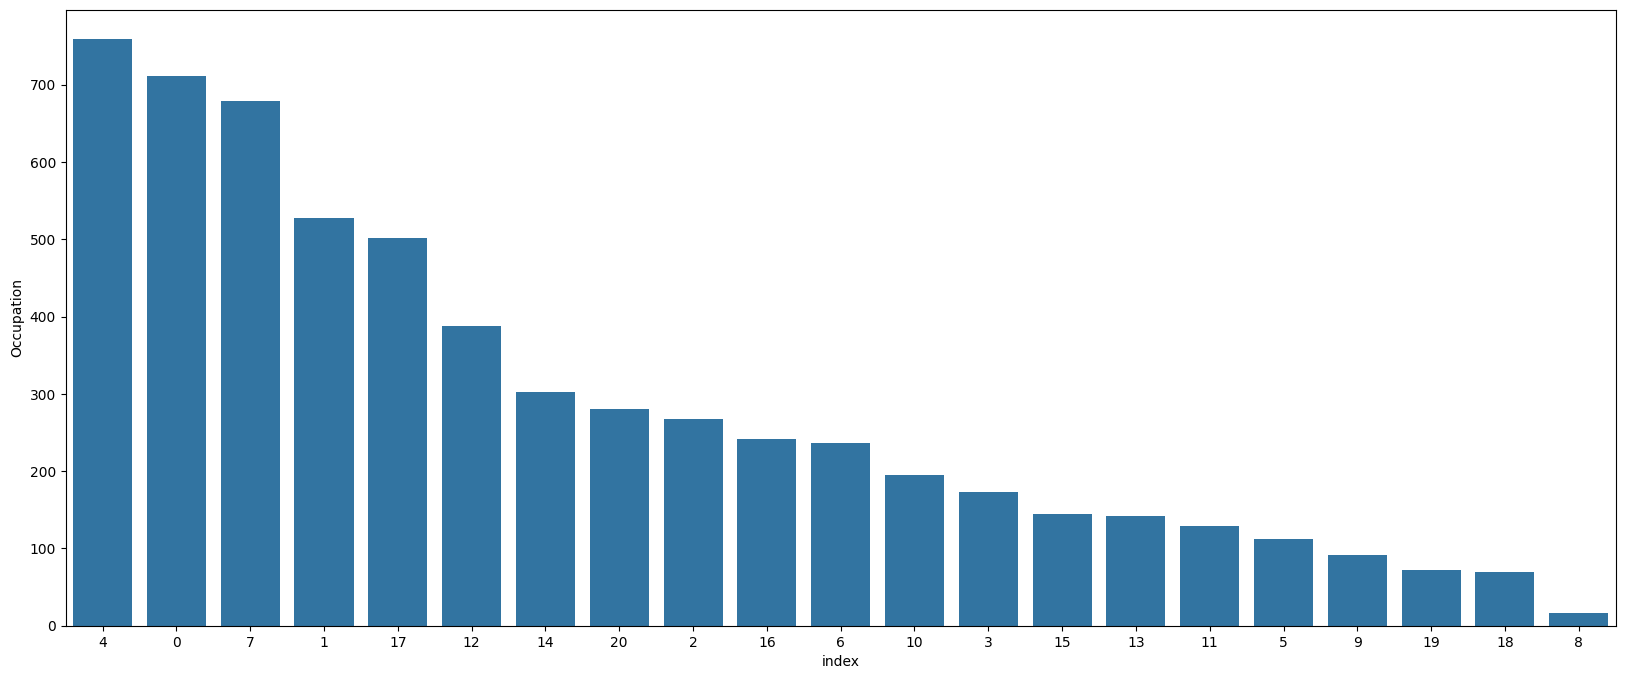

In [ ]:
plt.figure(figsize =(20,8))
sns.barplot(data= users["Occupation"].value_counts().reset_index(), x= "index", y="Occupation")

In [ ]:
users["Age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

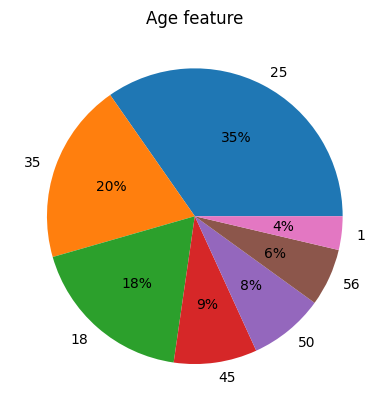

In [ ]:
plt.pie(x = users["Age"].value_counts().reset_index()["Age"],
        labels = users["Age"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Age feature")
plt.show()

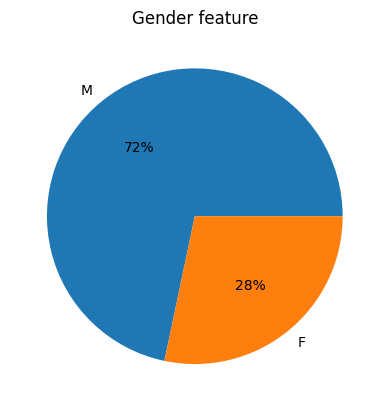

In [ ]:
plt.pie(x = users["Gender"].value_counts().reset_index()["Gender"],
        labels = users["Gender"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Gender feature")
plt.show()

In [ ]:
users["Zipcode"].value_counts().head(5)

48104    19
22903    18
55104    17
94110    17
55455    16
Name: Zipcode, dtype: int64

In [ ]:
users["Zipcode"].value_counts().tail(5)

80236    1
19428    1
33073    1
99005    1
14706    1
Name: Zipcode, dtype: int64

## Ratings

In [ ]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


In [ ]:
for i in ratings.columns:
  print("No of Unique {} are {}".format(i,ratings[i].nunique()))

No of Unique USerID are 6040
No of Unique Movie ID are 3706
No of Unique Rating are 5
No of Unique Timestamp are 458455
No of Unique hour are 24
No of Unique dayofweek are 7
No of Unique month are 12
No of Unique year are 4
No of Unique day are 31


In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
ratings["Rating"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

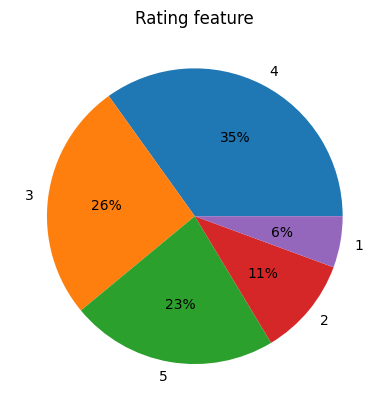

In [ ]:
plt.pie(x = ratings["Rating"].value_counts().reset_index()["Rating"],
        labels = ratings["Rating"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Rating feature")
plt.show()

<Axes: xlabel='hour', ylabel='count'>

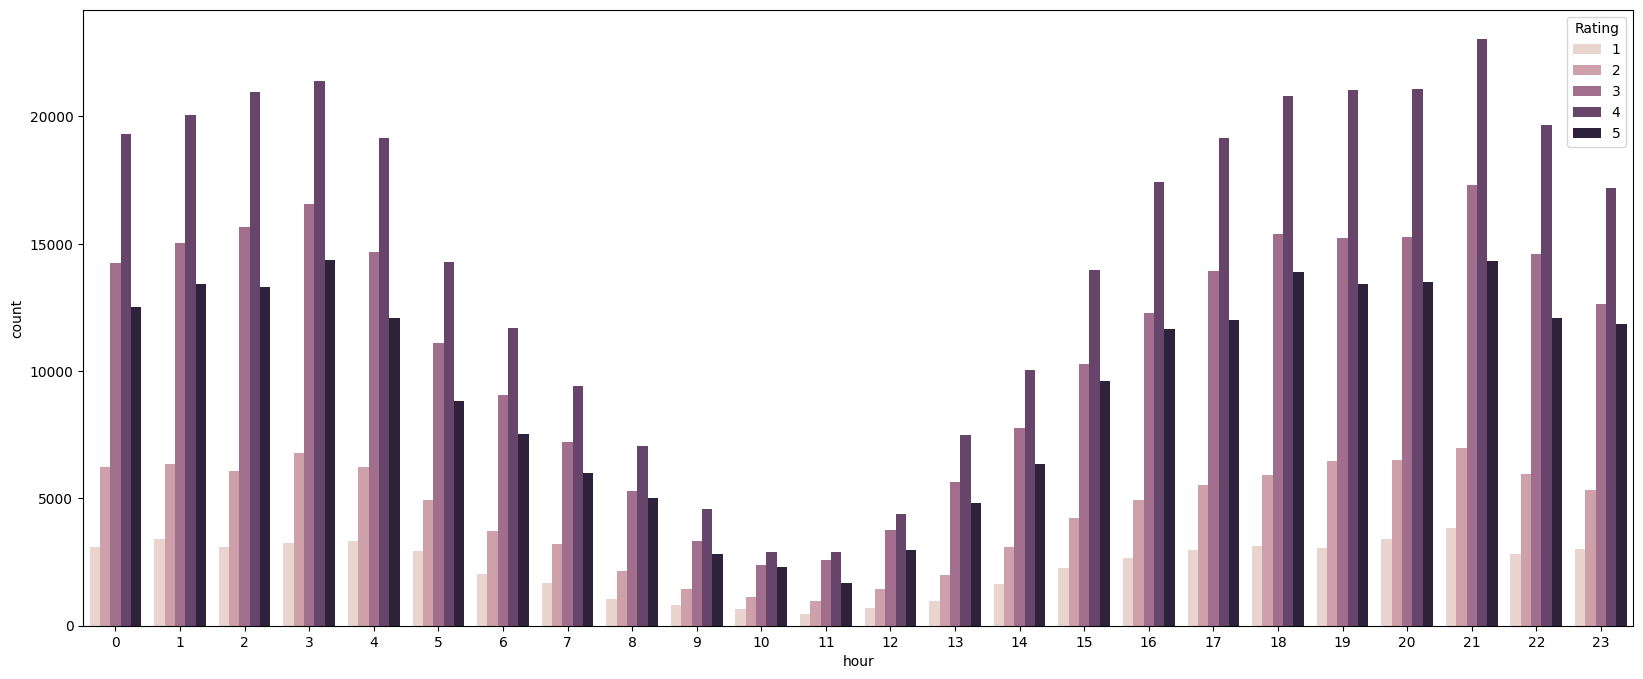

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "hour",hue = "Rating")

<Axes: xlabel='dayofweek', ylabel='count'>

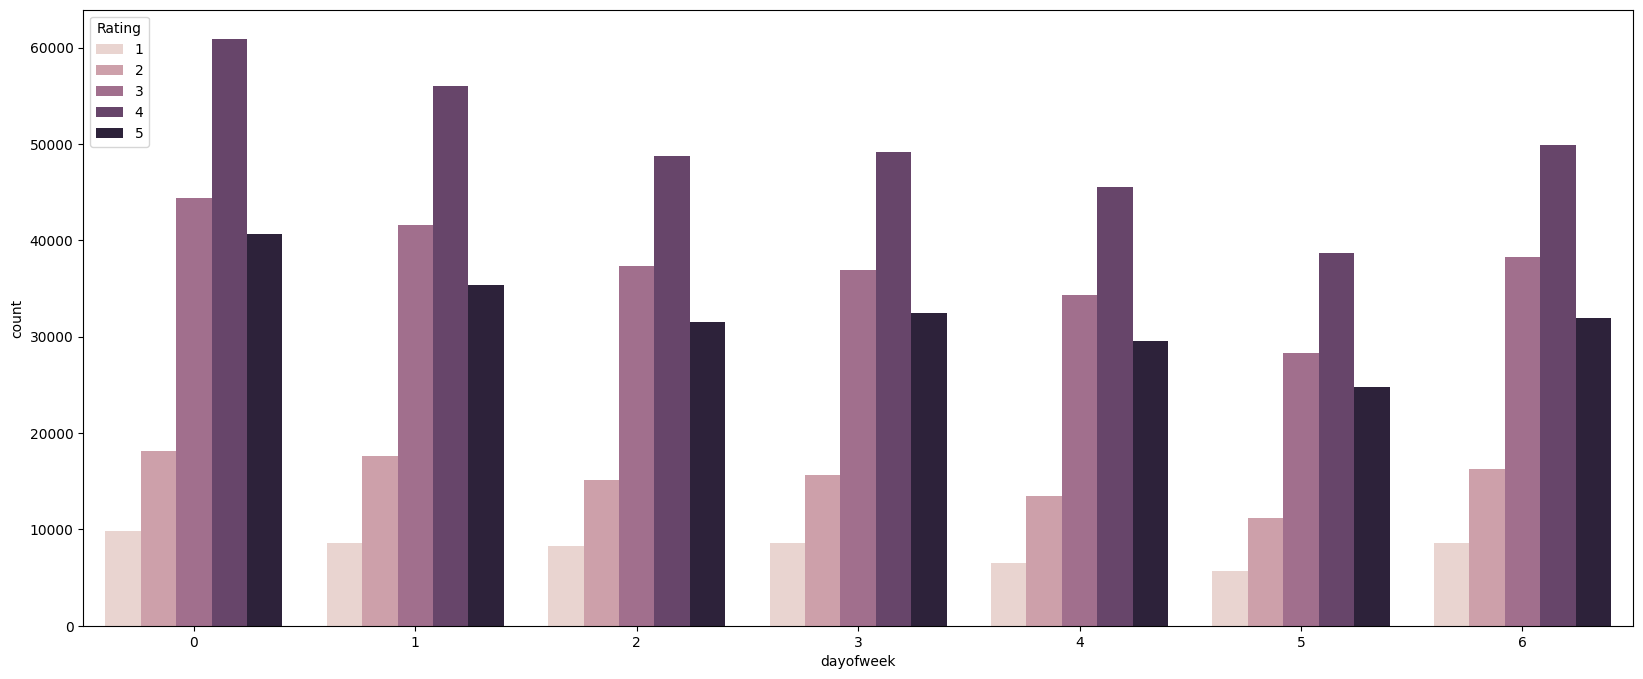

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "dayofweek",hue = "Rating")

<Axes: xlabel='month', ylabel='count'>

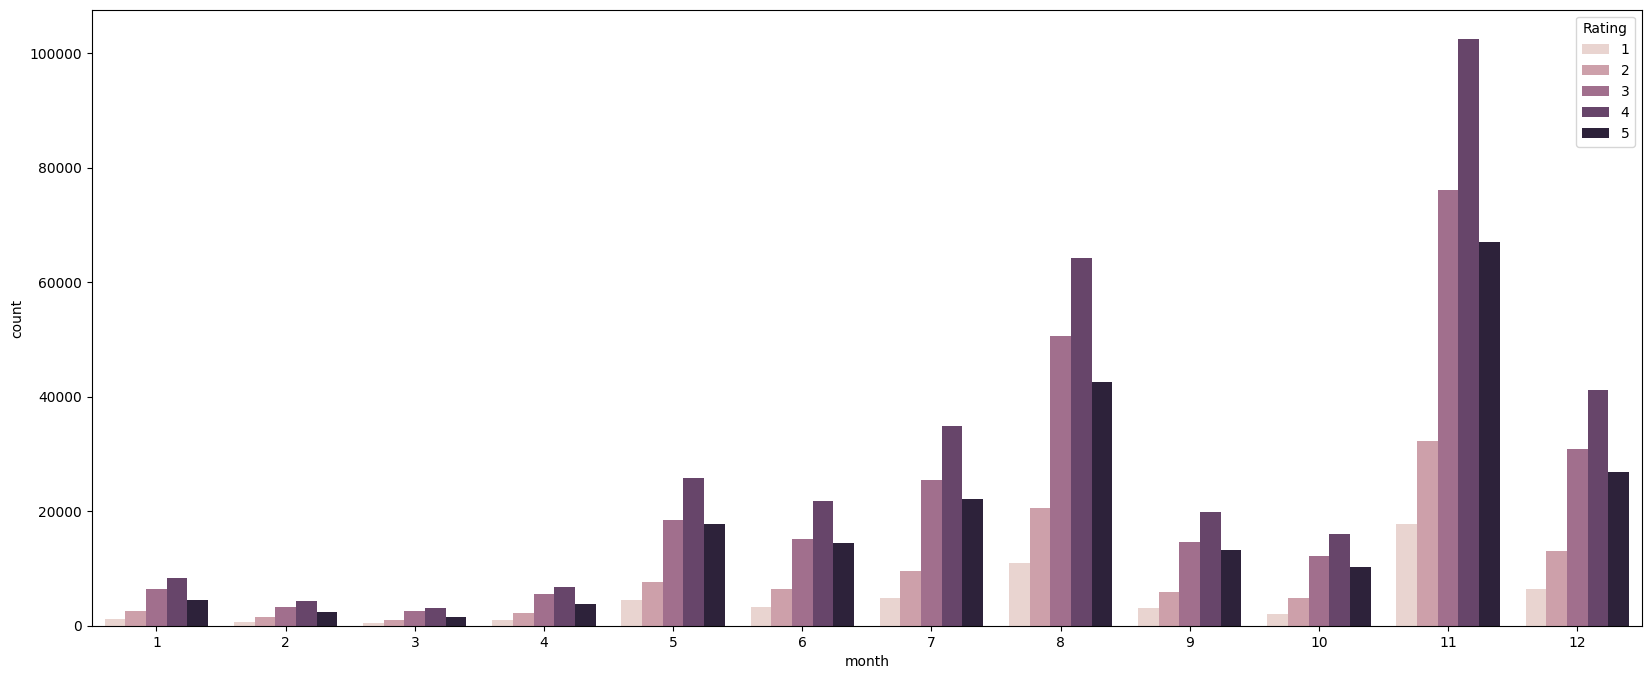

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "month",hue = "Rating")

<Axes: xlabel='year', ylabel='count'>

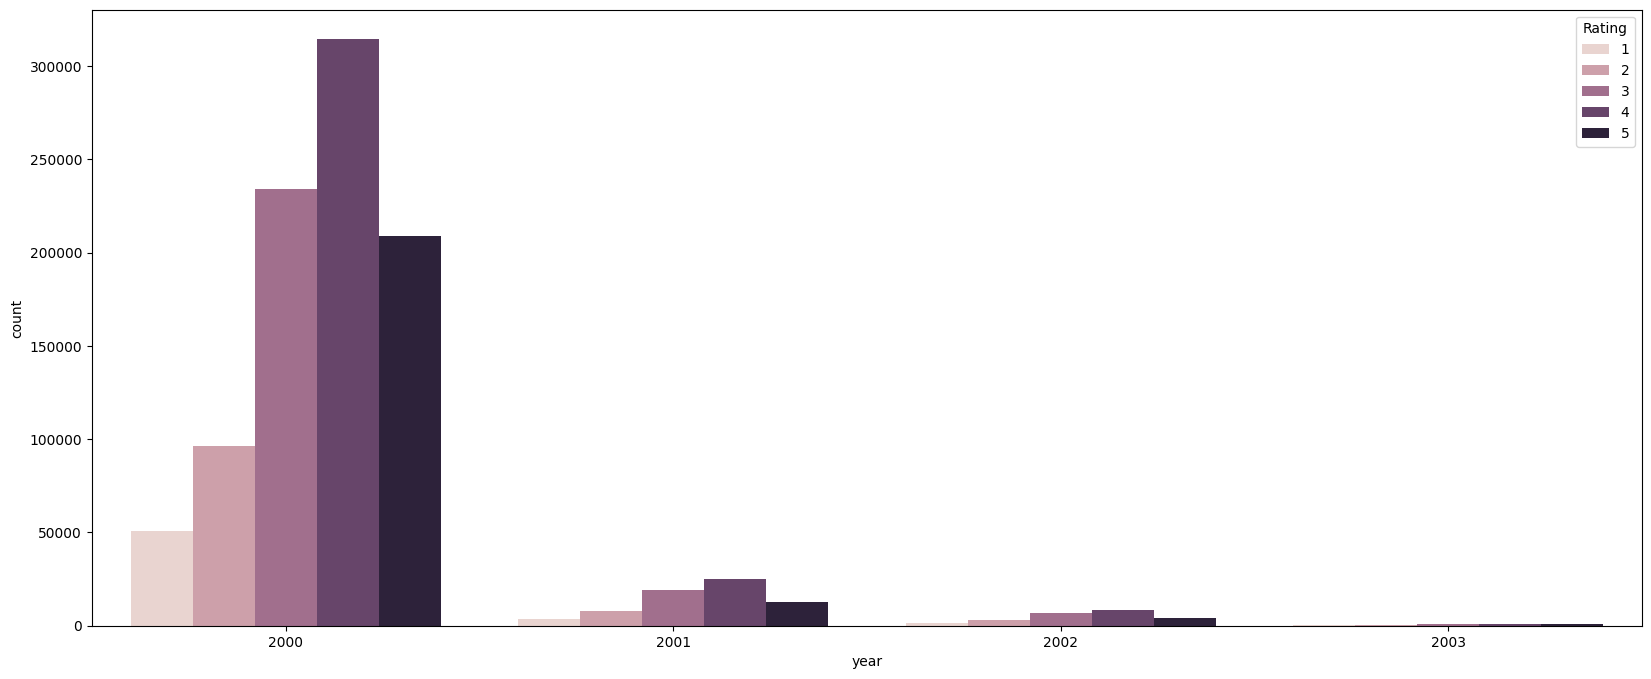

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "year",hue = "Rating")

In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

# Merging the Datasets

In [170]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Movie ID           6174 non-null   object  
 1   Title              6174 non-null   object  
 2   Genres             6174 non-null   category
 3   Releaseyear        6174 non-null   int64   
 4   Releaseyeargroups  6171 non-null   category
dtypes: category(2), int64(1), object(2)
memory usage: 205.9+ KB


In [141]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [142]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [ ]:
ratings.merge(users)

In [ ]:
# select_movies = ratings['movieId'].value_counts()[:1000].index.to_list()

In [ ]:
#movies = movies.loc[movies["movie Id"].isin(select_movies)]
#movies.shape

In [ ]:
#ratings = ratings.loc[ratings.movieId.isin(select_movies)]
#ratings.shape

In [230]:
data = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")

In [231]:
data = data.merge(movies[["Movie ID","Genres","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')

In [209]:
data.head(10)

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Genres,Releaseyeargroups,Releaseyear
0,1,1193,5,978300760,22,6,12,2000,31,F,1,10,Drama,3,1975
1,2,1193,5,978298413,21,6,12,2000,31,M,56,16,Drama,3,1975
2,12,1193,4,978220179,23,5,12,2000,30,M,25,12,Drama,3,1975
3,15,1193,4,978199279,18,5,12,2000,30,M,25,7,Drama,3,1975
4,17,1193,5,978158471,6,5,12,2000,30,M,50,1,Drama,3,1975
5,18,1193,4,978156168,6,5,12,2000,30,F,18,3,Drama,3,1975
6,19,1193,5,982730936,4,2,2,2001,21,M,1,10,Drama,3,1975
7,24,1193,5,978136709,0,5,12,2000,30,F,25,7,Drama,3,1975
8,28,1193,3,978125194,21,4,12,2000,29,F,25,1,Drama,3,1975
9,33,1193,5,978557765,21,2,1,2001,3,M,45,3,Drama,3,1975


* Now we have all the required information in one Dataframe, from this Dataframe we can extract specifica information for User-User and Item-Item Based Recommendation Approach

## Item-Item Approach

Lets Create a Matrix for Item[Movie]

In [210]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [235]:
item_item = movies[['Movie ID', 'Genressplit','Releaseyeargroups']]

In [212]:
item_item.head()

,Movie ID,Genressplit,Releaseyeargroups
0,1,Animation,5
0,1,Children's,5
0,1,Comedy,5
1,2,Adventure,5
1,2,Children's,5


### Adding Average Rating of an Item

In [237]:
item_item = item_item.merge(data.groupby('Movie ID').Rating.mean().reset_index(), on='Movie ID', how = "left")

In [238]:
item_item.head()

,Movie ID,Genressplit,Releaseyeargroups,Rating
0,1,Animation,5,4.146846
1,1,Children's,5,4.146846
2,1,Comedy,5,4.146846
3,2,Adventure,5,3.201141
4,2,Children's,5,3.201141


### Adding Gender wise Ratings for an item

In [242]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Gender'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Gender', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [243]:
item_item.head()

,Movie ID,Genressplit,Releaseyeargroups,Rating,F,M
0,1,Animation,5,4.146846,4.187817,4.130552
1,1,Children's,5,4.146846,4.187817,4.130552
2,1,Comedy,5,4.146846,4.187817,4.130552
3,2,Adventure,5,3.201141,3.278409,3.175238
4,2,Children's,5,3.201141,3.278409,3.175238


In [213]:
data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

### Adding Age wise Ratings for an item

In [244]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Age'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Age', values='Rating').
    reset_index(), on='Movie ID', how = "left")

### Adding Occupation wise Ratings for an item

In [245]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Occupation'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Occupation', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [246]:
item_item.head()

,Movie ID,Genressplit,Releaseyeargroups,Rating,F,M,1_x,18_x,25,35,...,19,2,20,3,4,5,6,7,8,9
0,1,Animation,5,4.146846,4.187817,4.130552,3.919643,4.017857,4.201266,4.302600,...,3.96,4.000000,4.046296,4.492537,4.040404,4.025641,4.394737,4.189055,4.500000,4.028571
1,1,Children's,5,4.146846,4.187817,4.130552,3.919643,4.017857,4.201266,4.302600,...,3.96,4.000000,4.046296,4.492537,4.040404,4.025641,4.394737,4.189055,4.500000,4.028571
2,1,Comedy,5,4.146846,4.187817,4.130552,3.919643,4.017857,4.201266,4.302600,...,3.96,4.000000,4.046296,4.492537,4.040404,4.025641,4.394737,4.189055,4.500000,4.028571
3,2,Adventure,5,3.201141,3.278409,3.175238,3.388889,2.993506,3.145594,3.307692,...,3.10,2.970588,3.071429,3.285714,3.116505,3.400000,3.107143,3.115942,2.666667,3.500000
4,2,Children's,5,3.201141,3.278409,3.175238,3.388889,2.993506,3.145594,3.307692,...,3.10,2.970588,3.071429,3.285714,3.116505,3.400000,3.107143,3.115942,2.666667,3.500000


In [247]:
item_item.columns

Index(['Movie ID', 'Genressplit', 'Releaseyeargroups', 'Rating', 'F', 'M',
       '1_x', '18_x', '25', '35', '45', '50', '56', '0', '1_y', '10', '11',
       '12', '13', '14', '15', '16', '17', '18_y', '19', '2', '20', '3', '4',
       '5', '6', '7', '8', '9'],
      dtype='object')